In [1]:
# Import necessary libraries
import os
import re
import glob

from tifffile import imread, imwrite
import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist
from scipy.spatial import cKDTree
from skimage.measure import regionprops

import matplotlib.pyplot as plt

In [2]:
def centroid(mask_bin):
    """Returns (y, x) centroid of boolean mask."""
    ys, xs = np.nonzero(mask_bin)
    if ys.size == 0:
        return None
    return (ys.mean(), xs.mean())

In [3]:
def detect_leakage(nuclear_mask_stack, reporter_mask_stack, reporter_img_stack, spots_df, dist_tol=5, area_factor=1.05):
    leakage_records = []
    centroid_pairs = []

    # Clean up tracking data
    spots_df.drop([0,1,2], axis=0, inplace=True) # Remove duplicated column names in from TrackMate's output
    spots_df = spots_df.reset_index()

    spots_df['POSITION_X'] = pd.to_numeric(spots_df['POSITION_X'], errors='coerce')
    spots_df['POSITION_Y'] = pd.to_numeric(spots_df['POSITION_Y'], errors='coerce')
    spots_df['FRAME'] = pd.to_numeric(spots_df['FRAME'], errors='coerce')

    # Drop rows where conversion failed (i.e., invalid entries became NaN)
    spots_df.dropna(subset=['POSITION_X', 'POSITION_Y','FRAME'], inplace=True)
    
    for frame in range(nuclear_mask_stack.shape[0]):
        tracking_this_frame = spots_df[spots_df['FRAME'] == frame]
        nuclear_mask = nuclear_mask_stack[frame]
        reporter_mask = reporter_mask_stack[frame]
        reporter_img = reporter_img_stack[frame]
    
        # Build reporter regionprops for this frame
        reporter_props = {p.label: p.centroid for p in regionprops(reporter_mask)}
        nuclear_props = {p.label: p.centroid for p in regionprops(nuclear_mask)}
    
        for _, trow in tracking_this_frame.iterrows():
            TRACK_ID = trow['TRACK_ID']
            x, y = int(round(trow['POSITION_X'])), int(round(trow['POSITION_Y']))
            nuc_label = nuclear_mask[y, x]
            if nuc_label == 0: continue
            nuc_mask_bin = (nuclear_mask == nuc_label)
            nuc_area = nuc_mask_bin.sum()
            nuc_centroid = centroid(nuc_mask_bin)
    
            # Find reporter masks within tolerance
            matches = []
            for rep_label, rep_centroid in reporter_props.items():
                dist = np.linalg.norm(np.array(nuc_centroid) - np.array(rep_centroid))
                if dist <= dist_tol:
                    matches.append((rep_label, dist))
            # Pick the closest (or largest overlap)
            if matches:
                # Choose by largest overlap (or could just pick first/closest)
                best_label = None
                max_overlap = 0
                for rep_label, _ in matches:
                    rep_mask_bin = (reporter_mask == rep_label)
                    overlap = np.logical_and(nuc_mask_bin, rep_mask_bin).sum()
                    if overlap > max_overlap:
                        max_overlap = overlap
                        best_label = rep_label
                rep_mask_bin = (reporter_mask == best_label)
                rep_area = rep_mask_bin.sum()
                rep_centroid = reporter_props[best_label]
    
                # Intensity calculations
                nuc_int = reporter_img[nuc_mask_bin].mean()
                # Cytoplasmic: reporter mask area minus nucleus
                cyto_mask_bin = np.logical_and(rep_mask_bin, ~nuc_mask_bin)
                cyto_int = reporter_img[cyto_mask_bin].mean() if cyto_mask_bin.sum() > 0 else 0.0
    
                leakage = rep_area > area_factor * nuc_area
    
            else:
                rep_area = 0
                rep_centroid = (np.nan, np.nan)
                nuc_int = reporter_img[nuc_mask_bin].mean()
                cyto_int = 0.0
                leakage = False
    
            leakage_records.append({
                'target_ID': TRACK_ID,
                'Frame': frame,
                'Leakage': leakage,
                'Nuc_Area': nuc_area,
                'Rep_Area': rep_area,
                'Nuc_Int': nuc_int,
                'Cyto_Int': cyto_int,
                'nuc_centroid_y': nuc_centroid[0], 'nuc_centroid_x': nuc_centroid[1],
                'rep_centroid_y': rep_centroid[0], 'rep_centroid_x': rep_centroid[1],
                'POSITION_X': x,
                'POSITION_Y': y,
            })
            centroid_pairs.append((frame, nuc_centroid, rep_centroid))
    
    leakage_df = pd.DataFrame(leakage_records)

    return leakage_df, centroid_pairs

In [4]:
def plot_overlap(reporter_img_stack, centroid_pairs, interval=10):
    n_frames = reporter_img_stack.shape[0]

    for frame_num in range(0,n_frames,interval):
        image = reporter_img_stack[frame_num]
        nuc_x, nuc_y, rep_x, rep_y = [], [], [], []
        
        for rec in [r for r in centroid_pairs if r[0] == frame_num]:
            y1, x1 = rec[1]
            y2, x2 = rec[2]
            nuc_x.append(x1)
            nuc_y.append(y1)
            rep_x.append(x2)
            rep_y.append(y2)
            
        plt.imshow(reporter_img_stack[frame_num], cmap='gray', alpha=0.6)
        plt.scatter(nuc_x, nuc_y, color='blue', alpha=0.5, s=80, label='Nucleus centroid')
        plt.scatter(rep_x, rep_y, color='red', alpha=0.5, s=80, label='Reporter centroid')
        plt.title(f'Frame {frame_num}: Overlapping blue+red = purple')
        plt.legend()
        plt.tight_layout()
        plt.show()

In [10]:
def add_status(target_df):
    # Adds the status and transition information of target cells
    max_frame = target_df['Frame'].max()

    # Assigns live/dead status based on whether the last frame the cell appeared in is smaller than the total number of frames
    last_frames = target_df.groupby('target_ID')['Frame'].max().reset_index()
    last_frames = last_frames.rename(columns={'Frame': 'Death_Frame'})
    last_frames['Target_State'] = last_frames['Death_Frame'].apply(
        lambda x: 'dead' if x < max_frame else 'alive'
    )
    
    target_df = pd.merge(target_df, last_frames, on='target_ID', how='left')

    # Adds transition frame information
    target_df['Death_Frame'] = target_df.apply(
        lambda row: row['Death_Frame'] if row['Target_State'] == 'dead' else pd.NA, axis=1
    )
    target_df['Death_Frame'] = target_df['Death_Frame'].astype('Int64')
    
    return target_df

In [6]:
def count_leakage(target_df):
    # Count number of leakage events per target
    target_df = target_df.sort_values(['target_ID', 'Frame']).reset_index(drop=True)

    # Compute event start indicators
    target_df['Leakage_Event'] = target_df.groupby('target_ID')['Leakage'].transform(lambda x: x & ~x.shift(fill_value=False))
    
    # Count per TRACK_ID
    leakage_counts = target_df.groupby('target_ID')['Leakage_Event'].sum().reset_index().rename(columns={'Leakage_Event': 'Leakage_Count'})
    
    # Merge with main df
    target_df = target_df.merge(leakage_counts, on='target_ID', how='left')

    # Drop leakage event start indicators
    target_df.drop('Leakage_Event', axis=1, inplace=True)

    return target_df

Processing sample1...


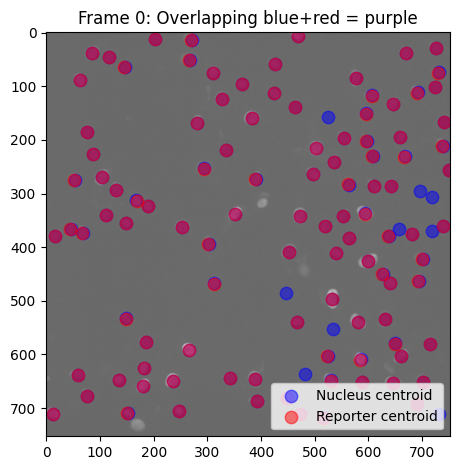

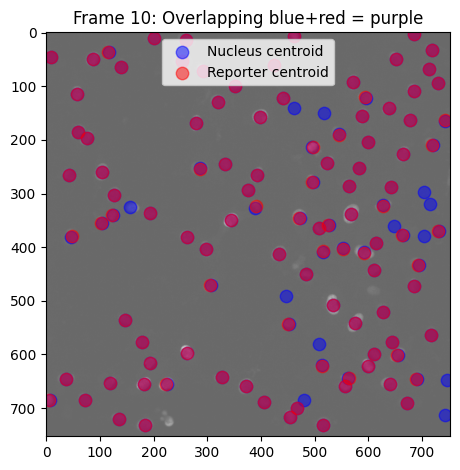

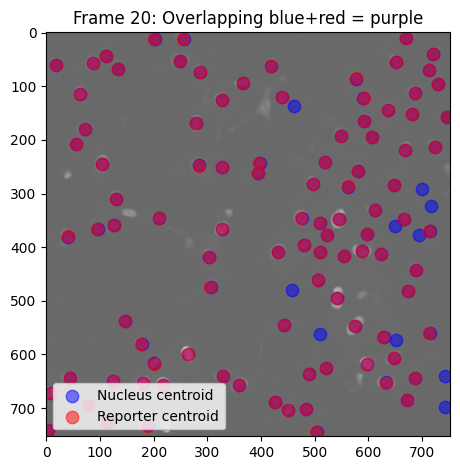

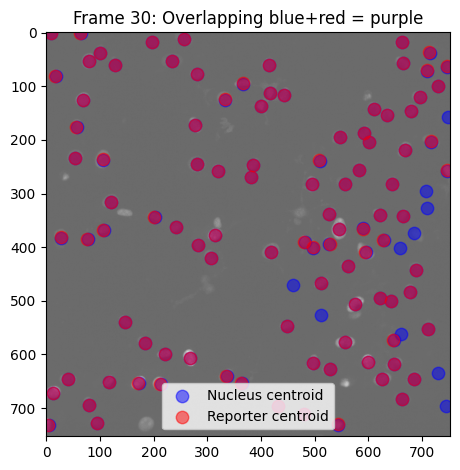

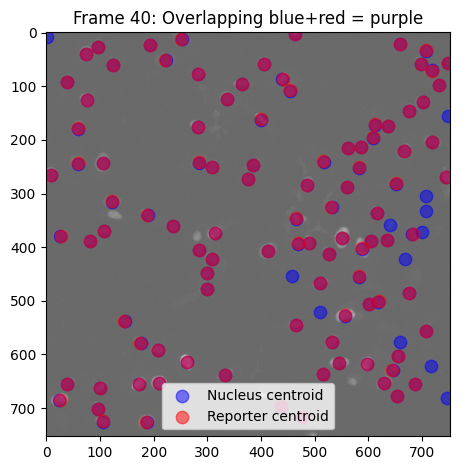

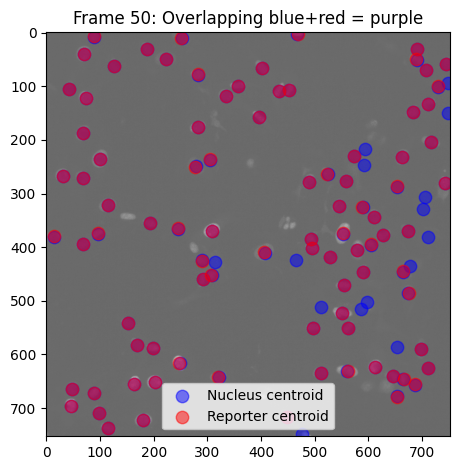

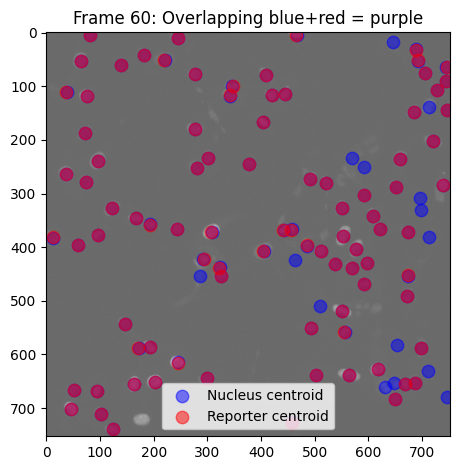

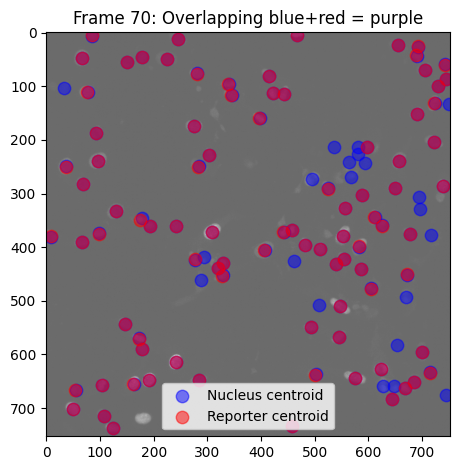

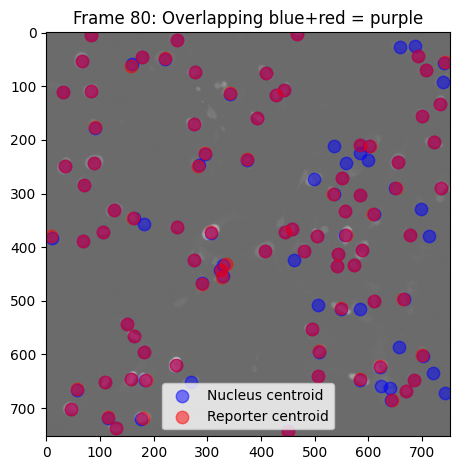

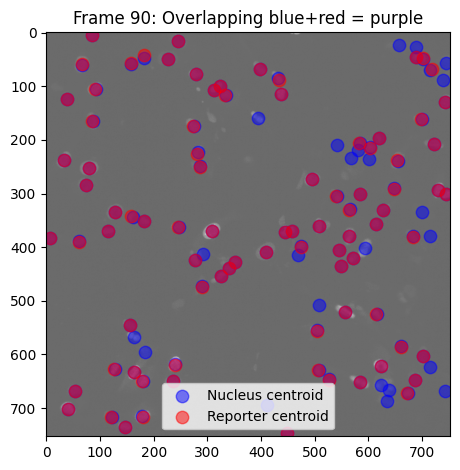

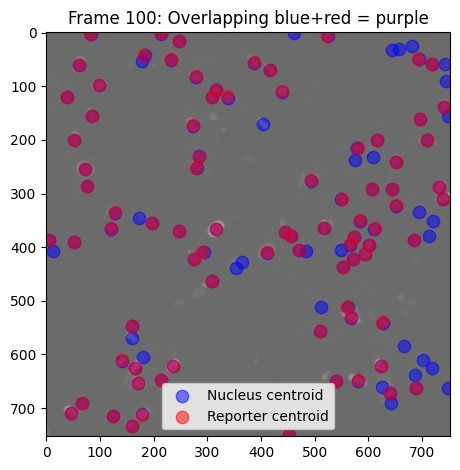

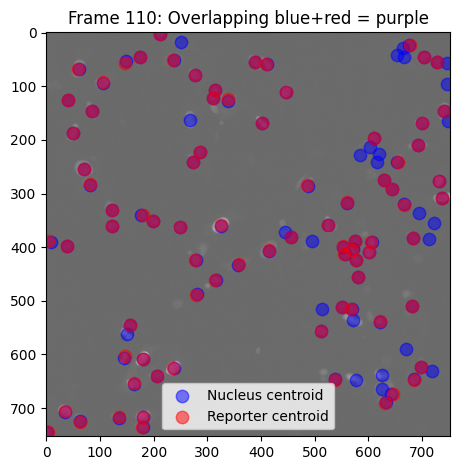

Finished sample1
Processing sample2...


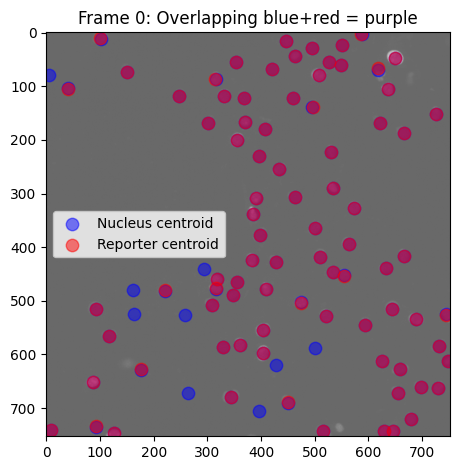

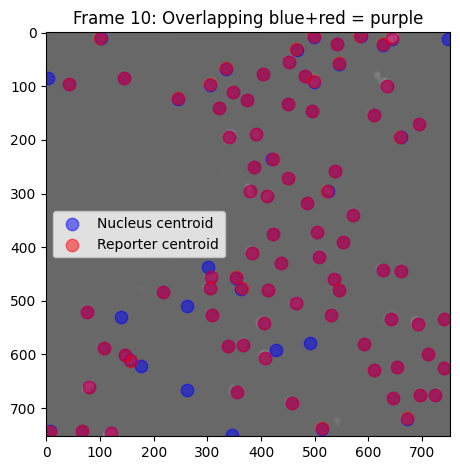

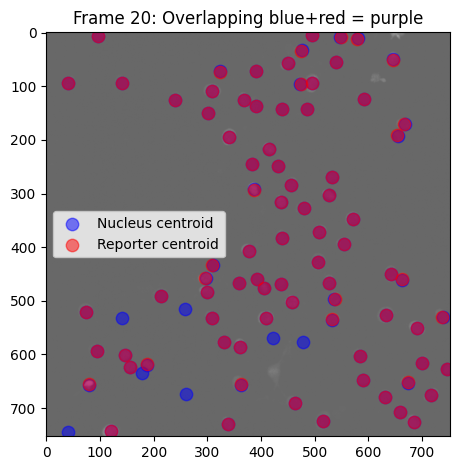

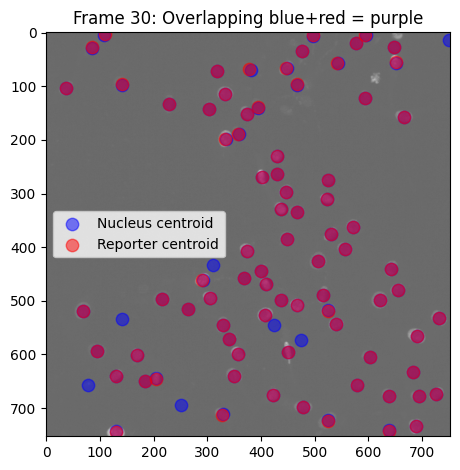

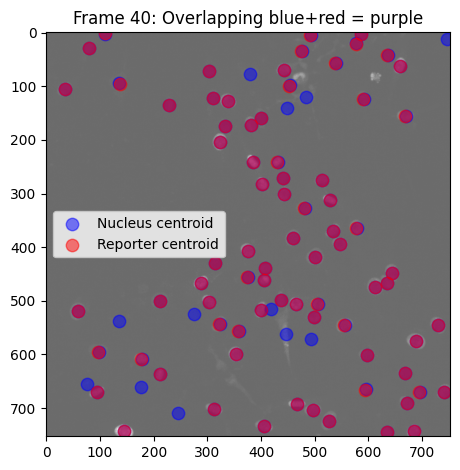

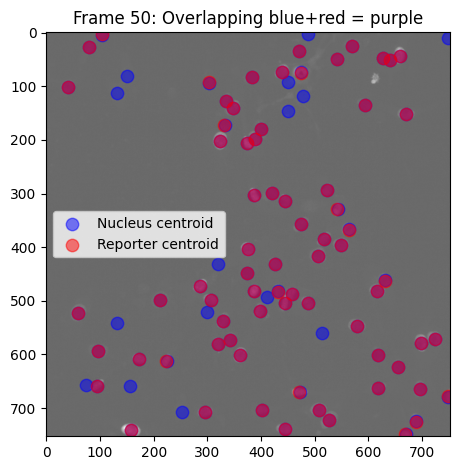

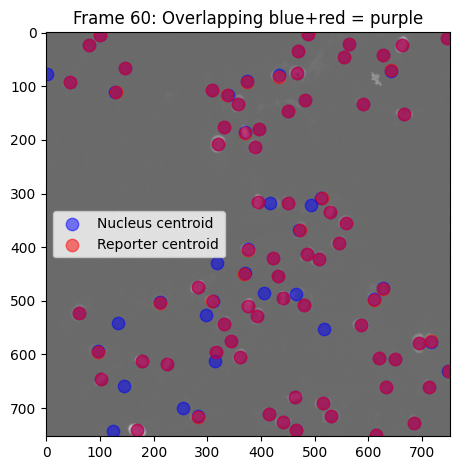

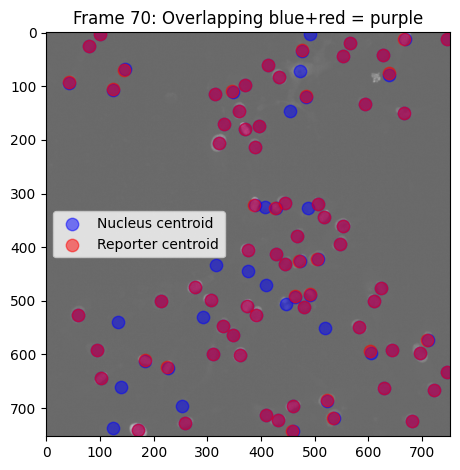

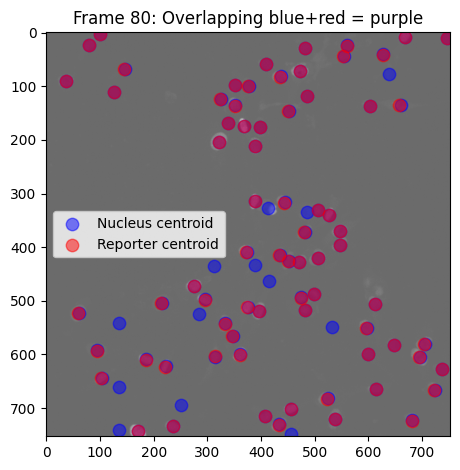

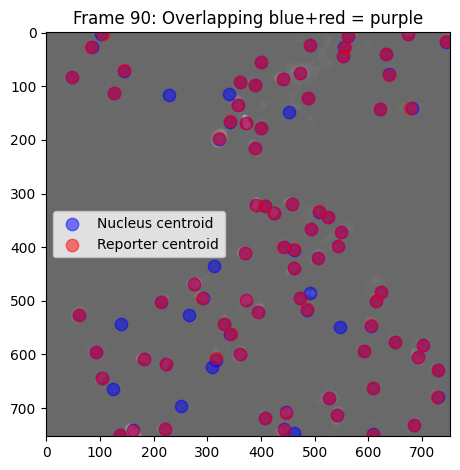

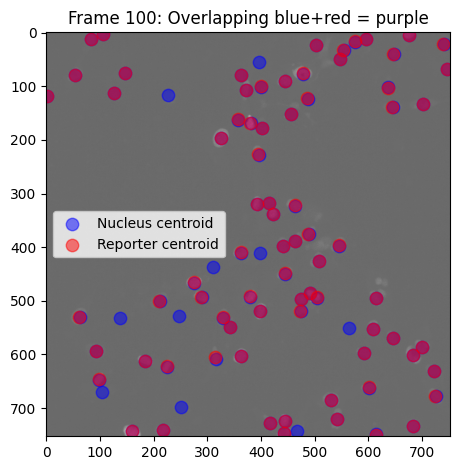

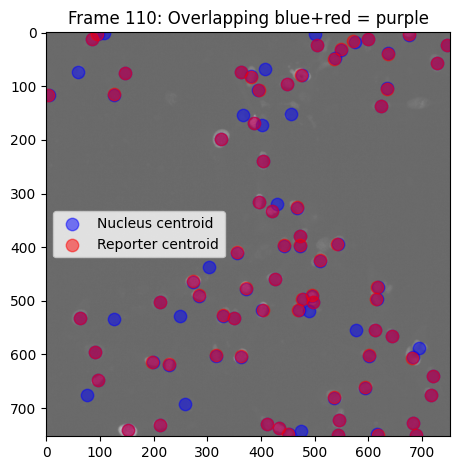

Finished sample2


In [11]:
master_folder = '/home/vil945/live_cell_imaging/2025-09-30_live_cell_imaging'

# Batch detect leakage
# Create output folder
exp_date = re.findall(r'\d{4}-\d{2}-\d{2}', master_folder)[0]
outdir = os.path.join(master_folder, f"{exp_date}_metrics", f"{exp_date}_leakage")
os.makedirs(outdir, exist_ok=True)

tracking_files = glob.glob(os.path.join(master_folder, '*tracking*', '*target_spots.csv')) # find tracking files

# Find sample indices from all tracking files
sample_indices = []
for f in tracking_files:
    m = re.search(r'(sample\d+)_target_spots\.csv', os.path.basename(f))
    if m:
        sample_indices.append(m.group(1))
sample_indices = sorted(set(sample_indices))

# Find reporter image and mask, nuclear mask
for idx in sample_indices:
    print(f'Processing {idx}...')
    # 1. Tracking
    tracking_fn = glob.glob(os.path.join(master_folder, '*tracking*', f'*{idx}_target_spots.csv'))
    # 2. Reporter image
    rep_img_fn = glob.glob(os.path.join(master_folder, '*GFP*', f'*{idx}_GFP.tif'))
    # 3. Reporter mask
    rep_mask_fn = glob.glob(os.path.join(master_folder, '*GFP*', '*GFP_segmented*', f'*segmented*{idx}_GFP.tif'))
    # 4. Nuclear mask
    nuc_mask_fn = glob.glob(os.path.join(master_folder, '*mCherry*', '*mCherry_segmented*', f'*segmented*{idx}_mCherry.tif'))

    # Basic file existence check
    if not (tracking_fn and rep_img_fn and rep_mask_fn and nuc_mask_fn):
        print(f"Missing files for {idx}! Skipping.")
        continue

    # Expand globs
    tracking_fn, rep_img_fn, rep_mask_fn, nuc_mask_fn = \
        tracking_fn[0], rep_img_fn[0], rep_mask_fn[0], nuc_mask_fn[0]

    # Read files
    tracking_df = pd.read_csv(tracking_fn)
    rep_img_stack = imread(rep_img_fn)    # intensity, shape (frames, Y, X)
    rep_mask_stack = imread(rep_mask_fn)  # mask, same shape as above
    nuc_mask_stack = imread(nuc_mask_fn)  # mask, same shape as above

    # Run leakage analysis
    leakage_df, centroid_pairs = detect_leakage(
        nuc_mask_stack, 
        rep_mask_stack, 
        rep_img_stack, 
        tracking_df, 
        dist_tol=5, 
        area_factor=1.05
    )

    # Plot overlap
    plot_overlap(rep_img_stack, centroid_pairs, interval=10)
    
    # Add status and count leakage
    status_leakage = add_status(leakage_df)
    final_leakage = count_leakage(status_leakage)

    # Save data
    leakage_csv = os.path.join(outdir, f'{exp_date}_{idx}_leakage.csv')
    final_leakage.to_csv(leakage_csv, index=False)

    print(f"Finished {idx}")

    